# Example: Population Dynamics for Quantum Spin Glasses

This notebook demonstrates how to use population dynamics to study the distribution of cavity fields under iteration, sampling over disorder rather than studying specific realizations.


In [ ]:
import sys
from pathlib import Path

# Ensure repository root (parent of src) is on sys.path
REPO_ROOT = Path.cwd()
if not (REPO_ROOT / "src").exists():
    REPO_ROOT = REPO_ROOT.parent
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot, gennorm

from src.population_dynamics import population_dynamics, message_update
from src.quantum_operators import full_mess
from src.analysis_utils import mean_excess_function


## Setup Parameters


In [9]:
# Population dynamics parameters
N = 3000              # Size of the population (number of cavity messages)
max_iter = 300000     # Maximum number of iterations
window_size = 30      # Window size for convergence check

# Physical parameters
K = 2                 # Coordination number
sigma = 1.0           # Standard deviation for coupling generation
G = 1              # Transverse field strength
T = 0.25              # Temperature
beta = 1 / T          # Inverse temperature

print(f"Population size: {N}")
print(f"Max iterations: {max_iter}")
print(f"K={K}, sigma={sigma}, G={G}, T={T}")


Population size: 3000
Max iterations: 300000
K=2, sigma=1.0, G=1, T=0.25


## Run Population Dynamics


In [10]:
# Run population dynamics
final_population_h, final_population_b, medians_h, medians_b, iqrs_h, iqrs_b, means_h, means_b, stds_h, stds_b = population_dynamics(
    N, max_iter, window_size, K, sigma, G, beta,
    message_update, full_mess
)

print(f"\nFinal statistics:")
print(f"  h: mean={means_h[-1]:.4f}, std={stds_h[-1]:.4f}, median={medians_h[-1]:.4f}, IQR={iqrs_h[-1]:.4f}")
print(f"  b: mean={means_b[-1]:.4f}, std={stds_b[-1]:.4f}, median={medians_b[-1]:.4f}, IQR={iqrs_b[-1]:.4f}")


Iteration 30000/300000...
Iteration 60000/300000...
Convergence achieved after 73897 iterations.

Final statistics:
  h: mean=0.0000, std=0.0000, median=0.0000, IQR=0.0000
  b: mean=0.2796, std=0.1281, median=0.2528, IQR=0.1777


## Analyze Convergence


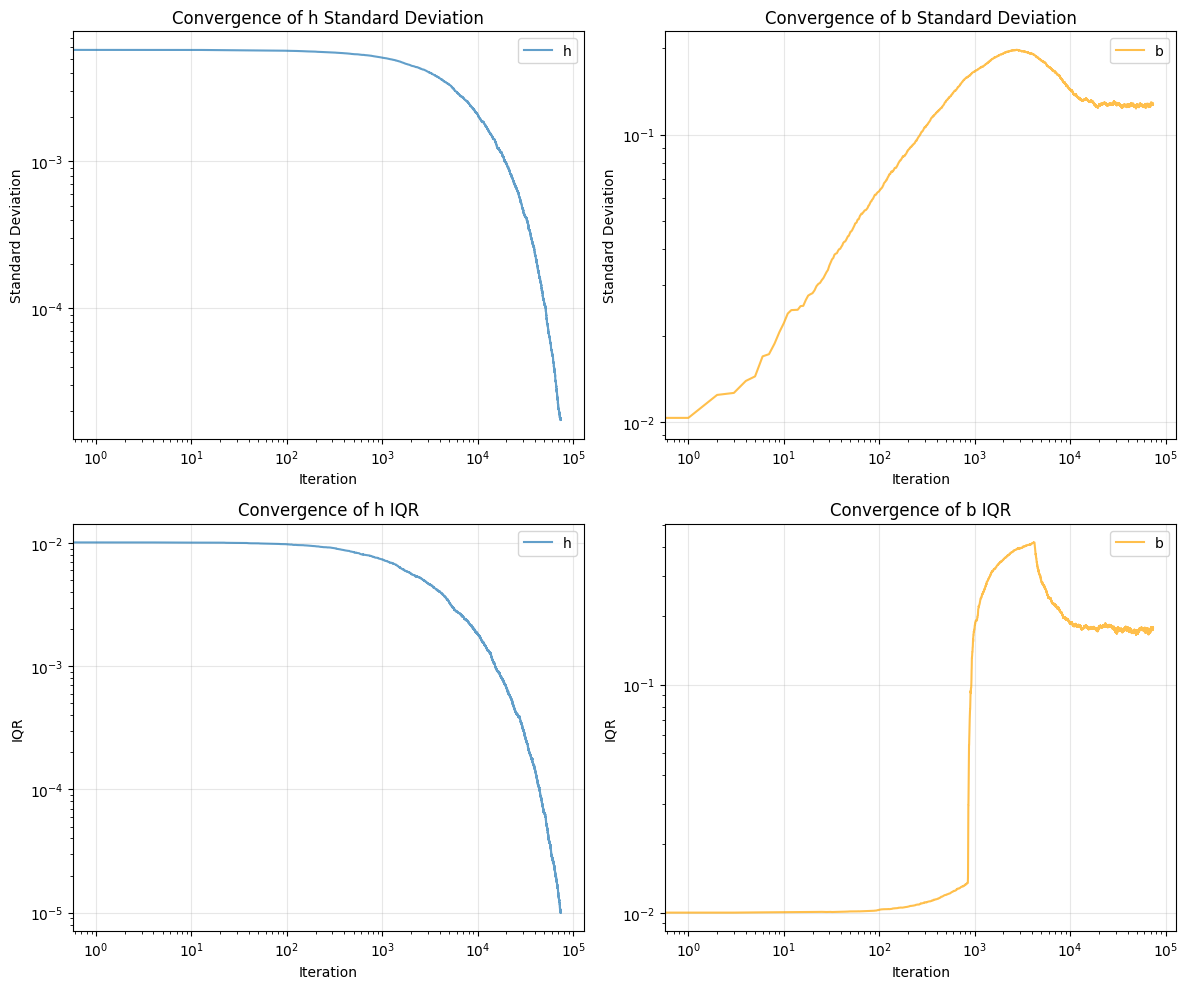

In [11]:
# Plot convergence of standard deviations and IQRs
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Standard deviations
axes[0, 0].loglog(stds_h, label='h', alpha=0.7)
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Standard Deviation')
axes[0, 0].set_title('Convergence of h Standard Deviation')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].loglog(stds_b, label='b', color='orange', alpha=0.7)
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Standard Deviation')
axes[0, 1].set_title('Convergence of b Standard Deviation')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# IQRs
axes[1, 0].loglog(iqrs_h, label='h', alpha=0.7)
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('IQR')
axes[1, 0].set_title('Convergence of h IQR')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].loglog(iqrs_b, label='b', color='orange', alpha=0.7)
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('IQR')
axes[1, 1].set_title('Convergence of b IQR')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Analyze Final Distributions


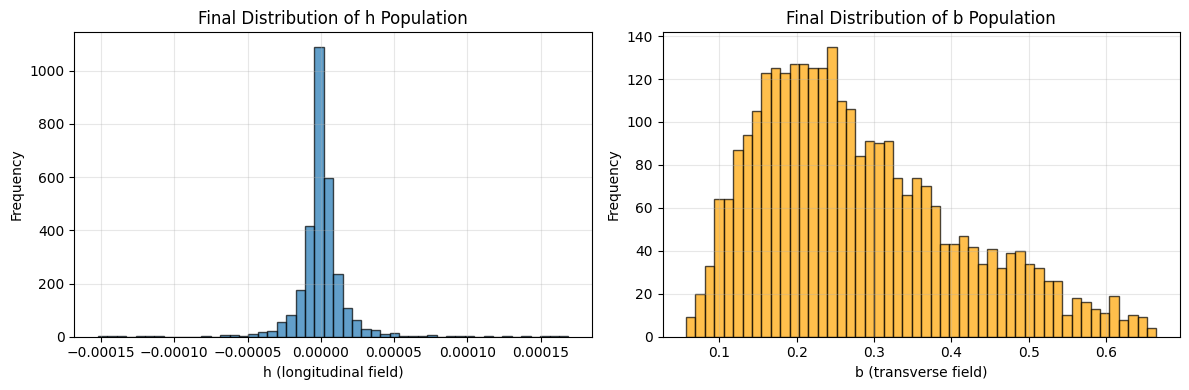

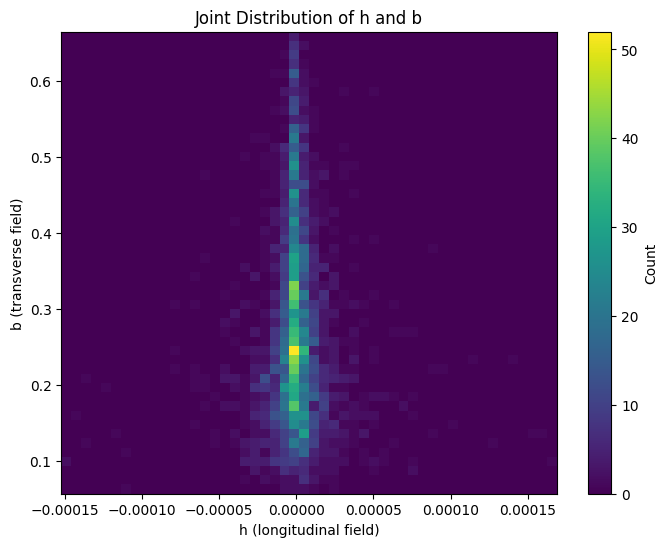

In [12]:
# Plot final distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(final_population_h, bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('h (longitudinal field)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Final Distribution of h Population')
axes[0].grid(True, alpha=0.3)

axes[1].hist(final_population_b, bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_xlabel('b (transverse field)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Final Distribution of b Population')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2D histogram
plt.figure(figsize=(8, 6))
plt.hist2d(final_population_h, final_population_b, bins=50, cmap='viridis')
plt.colorbar(label='Count')
plt.xlabel('h (longitudinal field)')
plt.ylabel('b (transverse field)')
plt.title('Joint Distribution of h and b')
plt.show()


## Tail Analysis of Population Distributions

Log-binned histograms and mean-excess-function (MEF) to characterize heavy tails.


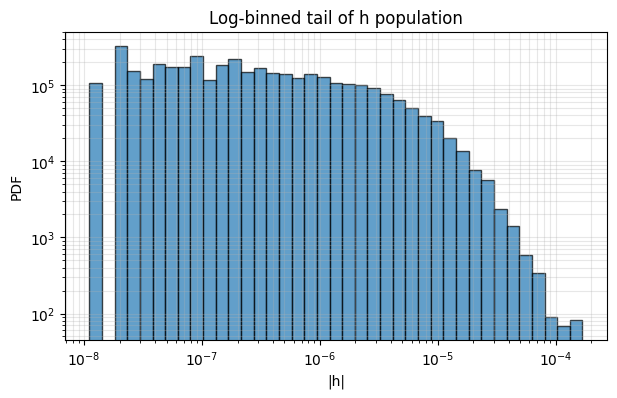

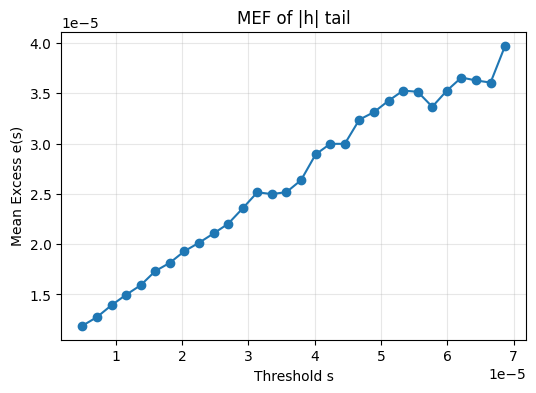

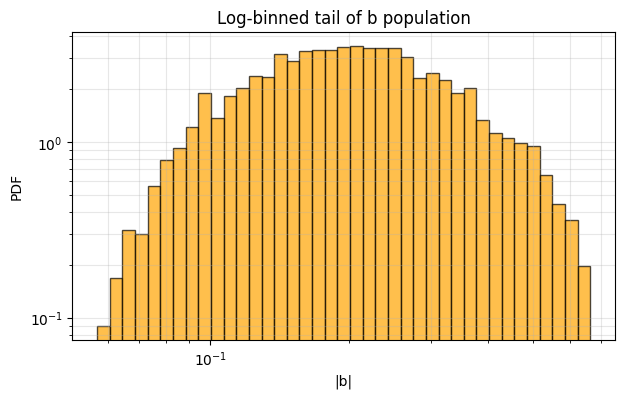

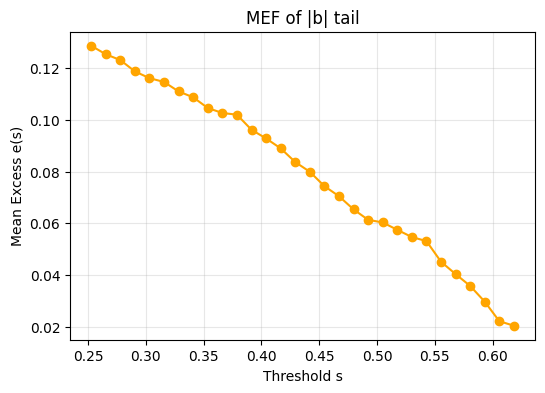

In [13]:
# Log-binned histogram for |h|
abs_h = np.abs(final_population_h)
logbins = np.logspace(np.log10(abs_h.min() + 1e-8), np.log10(abs_h.max()), 40)
plt.figure(figsize=(7, 4))
plt.hist(abs_h, bins=logbins, density=True, alpha=0.7, edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('|h|')
plt.ylabel('PDF')
plt.title('Log-binned tail of h population')
plt.grid(True, which='both', alpha=0.3)
plt.show()

# Mean Excess Function on |h|
s_values = np.linspace(np.percentile(abs_h, 50), np.percentile(abs_h, 99), 30)
valid_s, e_s = mean_excess_function(abs_h, s_values, min_exceedances=20)
plt.figure(figsize=(6, 4))
plt.plot(valid_s, e_s, 'o-')
plt.xlabel('Threshold s')
plt.ylabel('Mean Excess e(s)')
plt.title('MEF of |h| tail')
plt.grid(True, alpha=0.3)
plt.show()

# Repeat for |b|
abs_b = np.abs(final_population_b)
logbins_b = np.logspace(np.log10(abs_b.min() + 1e-8), np.log10(abs_b.max()), 40)
plt.figure(figsize=(7, 4))
plt.hist(abs_b, bins=logbins_b, density=True, alpha=0.7, edgecolor='black', color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('|b|')
plt.ylabel('PDF')
plt.title('Log-binned tail of b population')
plt.grid(True, which='both', alpha=0.3)
plt.show()

s_values_b = np.linspace(np.percentile(abs_b, 50), np.percentile(abs_b, 99), 30)
valid_sb, e_sb = mean_excess_function(abs_b, s_values_b, min_exceedances=20)
plt.figure(figsize=(6, 4))
plt.plot(valid_sb, e_sb, 'o-', color='orange')
plt.xlabel('Threshold s')
plt.ylabel('Mean Excess e(s)')
plt.title('MEF of |b| tail')
plt.grid(True, alpha=0.3)
plt.show()


## Normalized Distribution Analysis

Analyze the normalized distribution to check for deviations from Gaussian behavior.


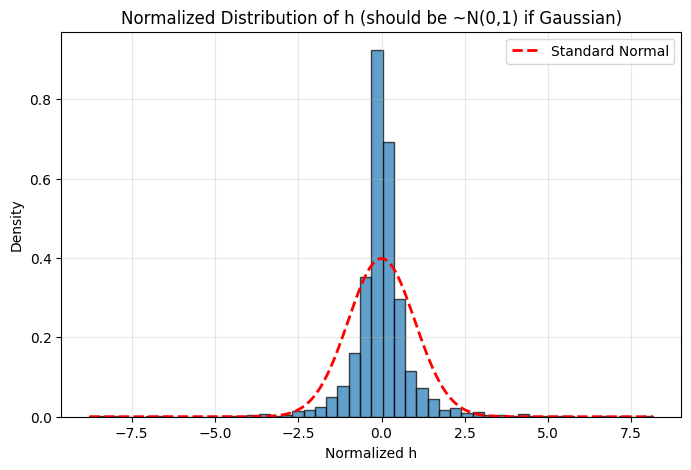

Excess Kurtosis: 16.1328


In [14]:
# Normalize the distribution
data = (final_population_h - means_h[-1]) / stds_h[-1]
# Remove extreme outliers for better visualization
data = data[abs(data) < np.percentile(abs(data), 99.9)]

plt.figure(figsize=(8, 5))
plt.hist(data, bins=50, alpha=0.7, edgecolor='black', density=True)
plt.xlabel('Normalized h')
plt.ylabel('Density')
plt.title('Normalized Distribution of h (should be ~N(0,1) if Gaussian)')
plt.grid(True, alpha=0.3)

# Overlay standard normal
from scipy.stats import norm
x = np.linspace(data.min(), data.max(), 200)
plt.plot(x, norm.pdf(x, 0, 1), 'r--', lw=2, label='Standard Normal')
plt.legend()
plt.show()

# Check kurtosis
from scipy.stats import kurtosis
excess_kurt = kurtosis(data) - 3
print(f"Excess Kurtosis: {excess_kurt:.4f}")

In [ ]:
# Q-Q plot against standard normal for normalized h
fig, ax = plt.subplots(figsize=(6, 4))
probplot(data, dist="norm", plot=ax)
ax.set_title("Q-Q plot of normalized h")
ax.grid(True, alpha=0.3)
plt.show()



In [ ]:
# Generalized Gaussian fit for h distribution
# Fit on centered data (use final_population_h) without hard clipping
h_mu, h_beta, h_sigma = gennorm.fit(final_population_h)

x_vals = np.linspace(final_population_h.min(), final_population_h.max(), 400)
fit_pdf = gennorm.pdf(x_vals, h_beta, loc=h_mu, scale=h_sigma)

plt.figure(figsize=(7, 4))
plt.hist(final_population_h, bins=60, density=True, alpha=0.6, edgecolor="black", label="Empirical")
plt.plot(x_vals, fit_pdf, "r--", lw=2, label=f"Gen. Gaussian (beta={h_beta:.2f})")
plt.xlabel("h")
plt.ylabel("Density")
plt.title("Generalized Gaussian fit of h")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



In [ ]:
# Tail analysis: log-log plot and power-law fit for |h| and |b|
abs_h = np.abs(final_population_h)
abs_b = np.abs(final_population_b)

# Choose upper tail (e.g., top 5%)
tail_cut = 95
h_tail = abs_h[abs_h >= np.percentile(abs_h, tail_cut)]
b_tail = abs_b[abs_b >= np.percentile(abs_b, tail_cut)]

# Fit power law: P(x) ~ x^{-alpha} => log P = -alpha log x + c
hist_h, edges_h = np.histogram(h_tail, bins=40, density=True)
centers_h = 0.5 * (edges_h[1:] + edges_h[:-1])
mask_h = (hist_h > 0)
alpha_h, logc_h = np.polyfit(np.log(centers_h[mask_h]), np.log(hist_h[mask_h]), 1)

hist_b, edges_b = np.histogram(b_tail, bins=40, density=True)
centers_b = 0.5 * (edges_b[1:] + edges_b[:-1])
mask_b = (hist_b > 0)
alpha_b, logc_b = np.polyfit(np.log(centers_b[mask_b]), np.log(hist_b[mask_b]), 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(centers_h[mask_h], hist_h[mask_h], 'o', label='empirical tail')
axes[0].plot(centers_h[mask_h], np.exp(logc_h + alpha_h*np.log(centers_h[mask_h])), 'r--', label=f'power-law fit (alpha={-alpha_h:.2f})')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('|h|')
axes[0].set_ylabel('PDF')
axes[0].set_title('Tail of |h|')
axes[0].grid(True, which='both', alpha=0.3)
axes[0].legend()

axes[1].plot(centers_b[mask_b], hist_b[mask_b], 'o', label='empirical tail')
axes[1].plot(centers_b[mask_b], np.exp(logc_b + alpha_b*np.log(centers_b[mask_b])), 'r--', label=f'power-law fit (alpha={-alpha_b:.2f})')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('|b|')
axes[1].set_ylabel('PDF')
axes[1].set_title('Tail of |b|')
axes[1].grid(True, which='both', alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

